# CESM Modeling
12/13/19

This project uses metadata from climate simulations from the Community Earth System Model2 (CESM2), obtained during my internship at the National Center for Atmospheric Research. The CESM2 log data was collected by parsing text-based timing files and saving in JSON format. This is public data.

To simulate climate over time, CESM2 runs different computational components such as atmosphere, ocean, sea ice, land ice, river runoff, wave, and land. The scientists can configure their model using different components and systems within each component, and they can map the resolution to different grids. 

I have prepared the data for modeling in CESM SQL and EDA - Thesis 2.ipynb, and here I will see if I can predict the run time of the model. The primary way to assess model performance is by looking at model cost, which is pe-hours/simulated year. Model cost is calculated by taking the time it takes the model to run (overall run time in seconds (wall clock time)), multiplied by the number of processors used in the simulation (pes), divided by the number of simulated years. Since we know the number of processors and simulated years in the runs, I will predict overall run time.

This notebook uses data from 9/19/19.

# Load Required Packages

In [1]:
#Load packages

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Load the Data  
CSV file prepped from CESM SQL and EDA - Thesis 2.ipynb

In [2]:
#Read df_NoOutlier.csv
df = pd.read_csv('df_ML-Thesis2.csv', sep=',')
del df['Unnamed: 0']

#View size of df
df.shape

(314961, 97)

In [3]:
#Show all columns
with pd.option_context("display.max_columns", 1000):
    display(df.head())

Id            LID  \
0   /glade/scratch/bdobbins/projects/Database/Gla...  180508-185620   
1   /glade/scratch/bdobbins/projects/Database/Gla...  181030-212017   
2   /glade/scratch/bdobbins/projects/Database/Gla...  181030-000151   
3   /glade/scratch/bdobbins/projects/Database/Gla...  150315-113454   
4   /glade/scratch/bdobbins/projects/Database/Gla...  140210-180221   

                                            Timeroot  \
0  /glade/p/work/sqliu/cesm1_2_2_1/scripts/Mojave...   
1  /gpfs/fs1/work/sqliu/cesm1_2_2_1/scripts/Mojav...   
2  /gpfs/fs1/work/sqliu/cesm1_2_2_1/scripts/Mojav...   
3  /glade/p/work/hannay/my_cases/f.e13.F2000C5.f0...   
4  /glade/u/home/dlawren/expts/permafrostRCN/clm4...   

                                                case  \
0                    Mojave_2x2_4paras_iter_EnKF_004   
1                         Mojave_2x2_Globe_trans_099   
2                         Mojave_2x2_Globe_trans_095   
3  f.e13.F2000C5.f09_f09_beta16.cam5.4_mills01_ca...   
4          clm45bgc_hrv_1DDD_1deg4508_rcp85_cIMPEDv2   

                                            caseroot  comp_pes_atm  \
0  /glade/p/work/sqliu/cesm1_2_2_1/scripts/Mojave...             1   
1  /gpfs/fs1/work/sqliu/cesm1_2_2_1/scripts/Mojav...             1   
2  /gpfs/fs1/work/sqliu/cesm1_2_2_1/scripts/Mojav...             1   
3  /glade/p/work/hannay/my_cases/f.e13.F2000C5.f0...           960   
4  /glade/u/home/dlawren/expts/permafrostRCN/clm4...            30   

   comp_pes_cpl  comp_pes_esp  comp_pes_glc  comp_pes_ice  comp_pes_lnd  \
0             1           NaN             1             1             1   
1             1           NaN             1             1             1   
2             1           NaN             1             1             1   
3           960           NaN           960           960           960   
4           600           NaN           600           600           600   

   comp_pes_ocn  comp_pes_rof  comp_pes_wav  \
0             1           1.0           1.0   
1             1           1.0           1.0   
2             1           1.0           1.0   
3           960         960.0         480.0   
4           600         600.0         600.0   

                                             compset            curr_date  \
0    2000_DATM%QIA_CLM45%BGC_SICE_SOCN_RTM_SGLC_SWAV  2018-05-09 00:58:12   
1    2000_DATM%QIA_CLM45%BGC_SICE_SOCN_RTM_SGLC_SWAV  2018-10-31 03:21:25   
2    2000_DATM%QIA_CLM45%BGC_SICE_SOCN_RTM_SGLC_SWAV  2018-10-30 06:02:35   
3  2000_CAM5_CLM40%SP_CICE%PRES_DOCN%DOM_RTM_SGLC...  2015-03-15 14:41:06   
4    20TR_DATM%CRU_CLM45%BGC_SICE_SOCN_RTM_SGLC_SWAV  2014-02-11 06:17:34   

   final_time                                               grid  \
0       0.000  a%CLM_USRDAT_l%CLM_USRDAT_oi%CLM_USRDAT_r%null...   
1       0.000  a%CLM_USRDAT_l%CLM_USRDAT_oi%CLM_USRDAT_r%null...   
2       0.000  a%CLM_USRDAT_l%CLM_USRDAT_oi%CLM_USRDAT_r%null...   
3       0.054  a%0.9x1.25_l%0.9x1.25_oi%0.9x1.25_r%r05_m%gx1v...   
4       0.036  a%0.9x1.25_l%0.9x1.25_oi%gx1v6_r%r05_m%gx1v6_g...   

   init_time_seconds  instances_atm  instances_esp  instances_glc  \
0             14.971            1.0            NaN            1.0   
1              9.349            1.0            NaN            1.0   
2              5.223            1.0            NaN            1.0   
3             72.980            1.0            NaN            1.0   
4             54.437            1.0            NaN            1.0   

   instances_ice  instances_lnd  instances_ocn  instances_rof  instances_wav  \
0            1.0            1.0            1.0            1.0            1.0   
1            1.0            1.0            1.0            1.0            1.0   
2            1.0            1.0            1.0            1.0            1.0   
3            1.0            1.0            1.0            1.0            1.0   
4            1.0            1.0            1.0            1.0            1.0   

       machine  model_cost

In [4]:
#For analysis later in the notebook
df_chey = df.copy()

## Set DateTime
Set curr_date as the datetime object:

In [5]:
#Change curr_date to datetime format
df['curr_date'] = pd.to_datetime(df.curr_date)
df['curr_date'].describe()

count                  314961
unique                 246953
top       2018-05-28 21:18:25
freq                       23
first     2013-04-25 23:47:41
last      2019-08-27 10:06:28
Name: curr_date, dtype: object

## Check Run Length
I believe that run_time_tot and run_time_seconds are duplicate columns.

In [6]:
#Look at run_length column
df.run_time_tot.describe()

count    314961.000000
mean       3814.622841
std        8864.285874
min           0.068000
25%           7.438000
50%          40.589000
75%        2035.826000
max      163286.378000
Name: run_time_tot, dtype: float64

In [7]:
df.run_time_tot.isna().sum()

0

In [8]:
df.run_time_seconds.describe()

count    314961.000000
mean       3814.622841
std        8864.285874
min           0.068000
25%           7.438000
50%          40.589000
75%        2035.826000
max      163286.378000
Name: run_time_seconds, dtype: float64

In [9]:
df.run_time_seconds.isna().sum()

0

In [10]:
#Confirmed that these columns are identical
#Delete run_time_seconds
del df['run_time_seconds']

# EDA
Basic exploratory data analysis on this data is covered in CESM SQL and EDA - Thesis 2.ipynb.

# Modeling  
Here, I will see if I can predict run_time_tot using ordinary least squares.  


## Prep Data for Modeling
First, I'll drop irrelevant columns and columns with multi-colinearity.

In [11]:
df_cheyenne = df[df.machine == 'cheyenne']

In [12]:
#Subset data to relevant features for modeling

#Drop identifying data like case names and IDs, etc.
df_modeling = df.drop(['Id', 'LID', 'Timeroot', 'case', 'caseroot', 'parser', 'user'], axis=1)

#Drop features that have multi-colinearity with other features
#Model cost, model throughput, CPU hours, and run_time_seconds_per_day are calculations that use run_time_tot
#Pe count is the total of separate counts of component pes
#Keep run_length_years but drop run_length_days
df_modeling = df_modeling.drop(['model_cost', 'model_throughput', 'pe_count', 'run_time_seconds_per_day',\
                                'run_length_days', 'CPU_hours'], axis=1)

#Drop run_time_xxx columns
df_modeling = df_modeling.drop(['run_time_atm', 'run_time_cpl', 'run_time_cplcomm', 'run_time_esp', \
                                'run_time_glc', 'run_time_ice', 'run_time_lnd', 'run_time_ocn', 'run_time_rof', \
                                'run_time_wav'], axis=1)

#Drop date, since it's an identifier for cases
#Drop compset and grid since their strings are parsed out individually
df_modeling = df_modeling.drop(['curr_date', 'compset', 'grid'], axis=1)

In [13]:
# comp_pes_xxx = tasks_xxx * threads_xxx, so I will use tasks and threads instead

#Drop any columns with 'comp_pes_xxx'
#df_modeling = df_modeling[df_modeling.columns.drop(list(df_modeling.filter(regex='comp_pes')))]

In [14]:
df_modeling.shape

(314961, 70)

In [15]:
df_modeling.machine.unique()

array(['cheyenne', 'yellowstone', 'cori-knl', 'mira', 'bluewaters'],
      dtype=object)

## Model Features  
Review columns in the dataset:

In [16]:
df_modeling.columns.values

array(['comp_pes_atm', 'comp_pes_cpl', 'comp_pes_esp', 'comp_pes_glc',
       'comp_pes_ice', 'comp_pes_lnd', 'comp_pes_ocn', 'comp_pes_rof',
       'comp_pes_wav', 'final_time', 'init_time_seconds', 'instances_atm',
       'instances_esp', 'instances_glc', 'instances_ice', 'instances_lnd',
       'instances_ocn', 'instances_rof', 'instances_wav', 'machine',
       'model_tag', 'ocn_init_wait_time', 'pes_per_node', 'root_pe_atm',
       'root_pe_cpl', 'root_pe_esp', 'root_pe_glc', 'root_pe_ice',
       'root_pe_lnd', 'root_pe_ocn', 'root_pe_rof', 'root_pe_wav',
       'run_time_tot', 'run_type', 'stop_option', 'tasks_atm',
       'tasks_cpl', 'tasks_esp', 'tasks_glc', 'tasks_ice', 'tasks_lnd',
       'tasks_ocn', 'tasks_rof', 'tasks_wav', 'threads_atm',
       'threads_cpl', 'threads_esp', 'threads_glc', 'threads_ice',
       'threads_lnd', 'threads_ocn', 'threads_rof', 'threads_wav',
       'run_length_years', 'compset_prefix', 'compset_atm',
       'compset_land', 'compset_sea_ice', 

I will start by using the following features in the model:  
  
-final_time (Time to shut down the model in seconds)    
-init_time_seconds (Time to initialize the model in seconds)  
-instances_xxx (Increments on the component for ensembles that run independently)  
-machine (Computing system running the model)  
-model_tag  
-ocn_init_wait_time  
-pes_per_node (Processor cores per node)  
-root_pe_xxx (Offset for MPI. Designates at which processor core (pe) the component starts)  
-run_type (Types: startup, hybrid, branch, or continue)  
-stop_option (Number of simulated days (ndays), months (nmonths), or years (nyears) in the run before suspending for resubmit. stop_n is the value of ndays, nmonths, or nyears.)   
-tasks_xxx (The total number of MPI tasks for the component)    
-threads_xxx (Threads for the component)  
-run_length_years (The length of the climate simulation (simulated years))   
-compset_xxx (Types of component in the model)
-grid_xxx (Type of grid per component)

-dependent variable: run_time_tot (Time the model ran (wall clock) in seconds) 

# Ordinary Least Squares
Ordinary least squares is a linear regression method that minimizes the sum of the squared errors between the observed data and the predictions.

First, subset the data by machine:

In [17]:
#Getting memory errors, so subset further by the five different machines
df_cheyenne = df_modeling[df_modeling.machine == 'cheyenne']
df_yellowstone = df_modeling[df_modeling.machine == 'yellowstone']
df_cori = df_modeling[df_modeling.machine == 'cori-knl']
df_mira = df_modeling[df_modeling.machine == 'mira']
df_bluewaters = df_modeling[df_modeling.machine == 'bluewaters']

## Mira

In [18]:
df_mira.shape

(202, 70)

In [19]:
#Check nulls
df_mira.isnull().sum() 

comp_pes_atm            0
comp_pes_cpl            0
comp_pes_esp          202
comp_pes_glc            0
comp_pes_ice            0
comp_pes_lnd            0
comp_pes_ocn            0
comp_pes_rof            0
comp_pes_wav            0
final_time              0
init_time_seconds       0
instances_atm           0
instances_esp         202
instances_glc           0
instances_ice           0
instances_lnd           0
instances_ocn           0
instances_rof           0
instances_wav           0
machine                 0
model_tag               0
ocn_init_wait_time      0
pes_per_node            0
root_pe_atm             0
root_pe_cpl             0
root_pe_esp           202
root_pe_glc             0
root_pe_ice             0
root_pe_lnd             0
root_pe_ocn             0
                     ... 
tasks_lnd               0
tasks_ocn               0
tasks_rof               0
tasks_wav               0
threads_atm             0
threads_cpl             0
threads_esp           202
threads_glc 

In [20]:
#Drop columns with nulls
df_mira = df_mira.drop(['instances_esp', 'root_pe_esp', 'threads_esp', 'compset_OBGC', 'tasks_esp', 'comp_pes_esp'], axis=1)

In [21]:
df_mira.isnull().sum()

comp_pes_atm          0
comp_pes_cpl          0
comp_pes_glc          0
comp_pes_ice          0
comp_pes_lnd          0
comp_pes_ocn          0
comp_pes_rof          0
comp_pes_wav          0
final_time            0
init_time_seconds     0
instances_atm         0
instances_glc         0
instances_ice         0
instances_lnd         0
instances_ocn         0
instances_rof         0
instances_wav         0
machine               0
model_tag             0
ocn_init_wait_time    0
pes_per_node          0
root_pe_atm           0
root_pe_cpl           0
root_pe_glc           0
root_pe_ice           0
root_pe_lnd           0
root_pe_ocn           0
root_pe_rof           0
root_pe_wav           0
run_time_tot          0
                     ..
tasks_glc             0
tasks_ice             0
tasks_lnd             0
tasks_ocn             0
tasks_rof             0
tasks_wav             0
threads_atm           0
threads_cpl           0
threads_glc           0
threads_ice           0
threads_lnd     

In [22]:
df_mira.columns.values

array(['comp_pes_atm', 'comp_pes_cpl', 'comp_pes_glc', 'comp_pes_ice',
       'comp_pes_lnd', 'comp_pes_ocn', 'comp_pes_rof', 'comp_pes_wav',
       'final_time', 'init_time_seconds', 'instances_atm',
       'instances_glc', 'instances_ice', 'instances_lnd', 'instances_ocn',
       'instances_rof', 'instances_wav', 'machine', 'model_tag',
       'ocn_init_wait_time', 'pes_per_node', 'root_pe_atm', 'root_pe_cpl',
       'root_pe_glc', 'root_pe_ice', 'root_pe_lnd', 'root_pe_ocn',
       'root_pe_rof', 'root_pe_wav', 'run_time_tot', 'run_type',
       'stop_option', 'tasks_atm', 'tasks_cpl', 'tasks_glc', 'tasks_ice',
       'tasks_lnd', 'tasks_ocn', 'tasks_rof', 'tasks_wav', 'threads_atm',
       'threads_cpl', 'threads_glc', 'threads_ice', 'threads_lnd',
       'threads_ocn', 'threads_rof', 'threads_wav', 'run_length_years',
       'compset_prefix', 'compset_atm', 'compset_land', 'compset_sea_ice',
       'compset_ocn', 'compset_river', 'compset_land_ice', 'compset_wave',
       'grid_at

In [23]:
df_mira = df_mira.drop(['stop_option'], axis=1)

In [24]:
#Create dummy variables from categorical data
from sklearn.model_selection import train_test_split
data_dummies = pd.get_dummies(df_mira, drop_first=True)
data_dummies.shape

y = data_dummies.run_time_tot                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Create training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
#Run the OLS regression
model = sm.OLS(yTrain, xTrain)
#Fit the model
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           run_time_tot   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     533.9
Date:                Tue, 17 Dec 2019   Prob (F-statistic):          1.09e-109
Time:                        19:52:28   Log-Likelihood:                -1489.9
No. Observations:                 161   AIC:                             3000.
Df Residuals:                     151   BIC:                             3031.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

Text(0, 0.5, 'Density')

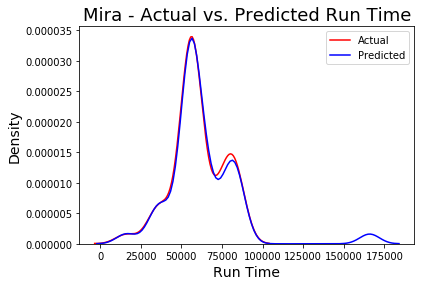

In [25]:
preds = results.predict(xTest)
import seaborn as sns
ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
ax1.set_title("Mira - Actual vs. Predicted Run Time", fontsize=18)
sns.distplot(preds, hist=False, color="b", label="Predicted" , ax=ax1)

plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

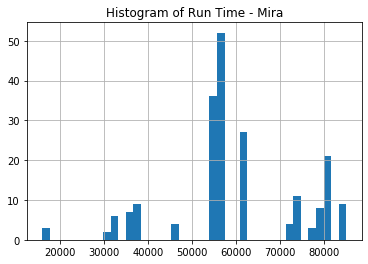

In [26]:
#Histogram of run time
plt.title('Histogram of Run Time - Mira')
df_mira.run_time_tot.hist(bins=40)

I get predictions around 160,000 seconds, but there are no actual values above 85,000. I'll keep working on this model:

### Select Features

In [27]:
#Subset just a few columns
df_mira_select = df_mira[['final_time', 'run_length_years', 'run_type', 'run_time_tot']]

In [28]:
#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_mira_select, drop_first=True)
data_dummies.shape

y = data_dummies.run_time_tot                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

#Model
model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           run_time_tot   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.067e+04
Date:                Tue, 17 Dec 2019   Prob (F-statistic):                   4.69e-200
Time:                        19:52:29   Log-Likelihood:                         -1518.1
No. Observations:                 161   AIC:                                      3048.
Df Residuals:                     155   BIC:                                      3067.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                                               coef    std err          t      P>|t|      [0.025      0.

In [29]:
df = pd.DataFrame(results.params)
df = df.reset_index()
df.columns = (['Feature', 'Coef'])
df = df.sort_values(by=['Coef'])
df

Feature          Coef
4  run_type_hybrid, continue_run = TRUE (inittype... -4.584229e+03
6  run_type_startup, continue_run = TRUE (inittyp... -3.517509e+03
5  run_type_startup, continue_run = FALSE (initty... -1.292272e+03
3  run_type_hybrid, continue_run = FALSE (inittyp...  5.954023e-12
2  run_type_branch, continue_run = TRUE (inittype...  4.921452e+03
0                                         final_time  2.962558e+04
1                                   run_length_years  5.022584e+04

In [30]:
#Plot Correlation Coefficients
df = pd.DataFrame(results.params)
df = df.reset_index()
df.columns = (['Feature', 'Coef'])
df = df.sort_values(by=['Coef'])

import plotly.express as px
fig = px.bar(df, y="Feature", x="Coef", orientation='h', title ='Mira - Correlation Coefficient Importance')
fig.show()

In [31]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html
#dir(results)

Text(0, 0.5, 'Density')

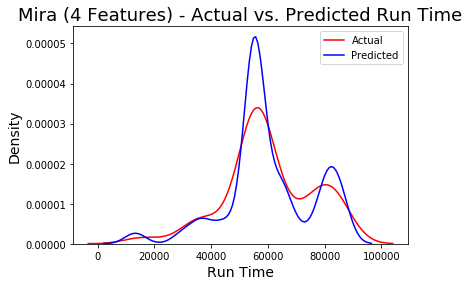

In [32]:
preds = results.predict(xTest)
import seaborn as sns
ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
ax1.set_title("Mira (4 Features) - Actual vs. Predicted Run Time", fontsize=18)
sns.distplot(preds, hist=False, color="b", label="Predicted" , ax=ax1)

plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

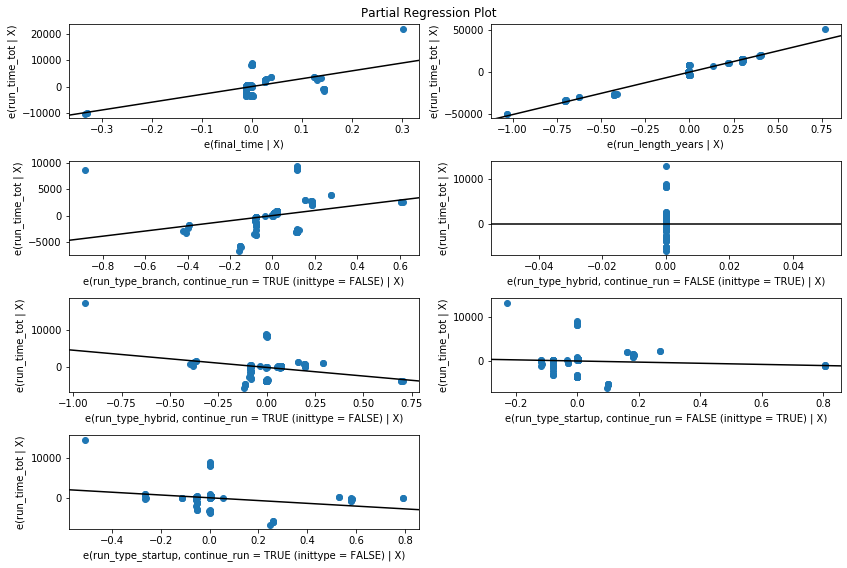

In [33]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results, fig=fig)

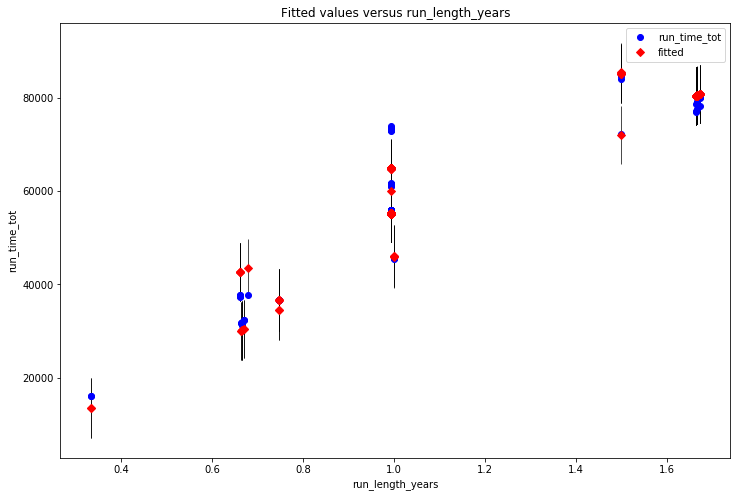

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(results, "run_length_years", ax=ax)

In [35]:
#Residuals vs. Fitted?
#df1 = pd.DataFrame(results.resid)
#df1 = df1.reset_index()
#df1.columns = (['index', 'Residuals'])
#df2 = pd.DataFrame(results.fittedvalues)
#df2= df2.reset_index()
#df2.columns = (['index', 'Fitted'])

#df3 = pd.merge(df1, df2, on = 'index')
#df3

Better with fewer features!

## Bluewaters

In [36]:
df_bluewaters.shape

(305, 70)

In [37]:
df_bluewaters.isnull().sum()

comp_pes_atm            0
comp_pes_cpl            0
comp_pes_esp          305
comp_pes_glc            0
comp_pes_ice            0
comp_pes_lnd            0
comp_pes_ocn            0
comp_pes_rof            0
comp_pes_wav            0
final_time              0
init_time_seconds       0
instances_atm           0
instances_esp         305
instances_glc           0
instances_ice           0
instances_lnd           0
instances_ocn           0
instances_rof           0
instances_wav           0
machine                 0
model_tag               0
ocn_init_wait_time      0
pes_per_node            0
root_pe_atm             0
root_pe_cpl             0
root_pe_esp           305
root_pe_glc             0
root_pe_ice             0
root_pe_lnd             0
root_pe_ocn             0
                     ... 
tasks_lnd               0
tasks_ocn               0
tasks_rof               0
tasks_wav               0
threads_atm             0
threads_cpl             0
threads_esp           305
threads_glc 

In [38]:
#Drop columns with nulls
df_bluewaters = df_bluewaters.drop(['instances_esp', 'root_pe_esp', 'threads_esp', 'compset_OBGC', 'tasks_esp', \
                                   'comp_pes_esp'], axis=1)

In [39]:
#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_bluewaters, drop_first=True)
data_dummies.shape

y = data_dummies.run_time_tot                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

#Model
model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           run_time_tot   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2821.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):          1.18e-259
Time:                        19:52:35   Log-Likelihood:                -2200.4
No. Observations:                 244   AIC:                             4459.
Df Residuals:                     215   BIC:                             4560.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

Text(0, 0.5, 'Density')

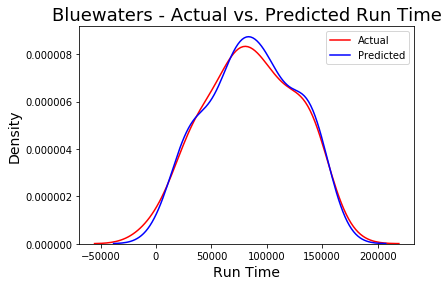

In [40]:
preds = results.predict(xTest)
 
ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
ax1.set_title("Bluewaters - Actual vs. Predicted Run Time", fontsize = 18)
sns.distplot(preds, hist=False, color="b", label="Predicted" , ax=ax1)
plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

Text(0, 0.5, 'Density')

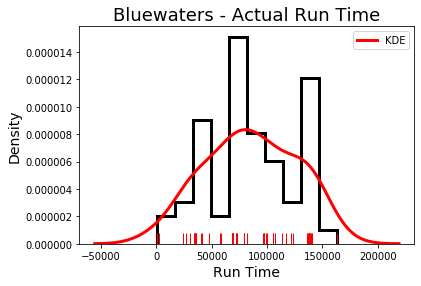

In [41]:
ax = sns.distplot(yTest, rug=True, rug_kws={"color": "r"}, bins = 10,
                 kde_kws={"color": "r", "lw": 3, "label": "KDE"},
                 hist_kws={"histtype": "step", "linewidth": 3,
                           "alpha": 1, "color": "k"})
ax.set_title("Bluewaters - Actual Run Time", fontsize=18)
plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

Text(0, 0.5, 'Density')

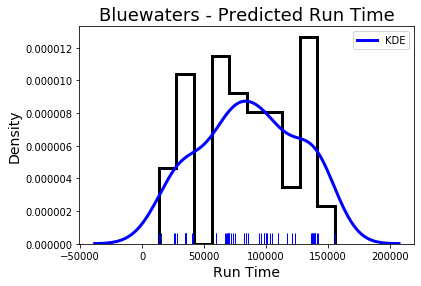

In [42]:
ax = sns.distplot(preds, rug=True, rug_kws={"color": "b"}, bins = 10,
                 kde_kws={"color": "b", "lw": 3, "label": "KDE"},
                 hist_kws={"histtype": "step", "linewidth": 3,
                           "alpha": 1, "color": "k"})
ax.set_title("Bluewaters - Predicted Run Time", fontsize=18)
plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

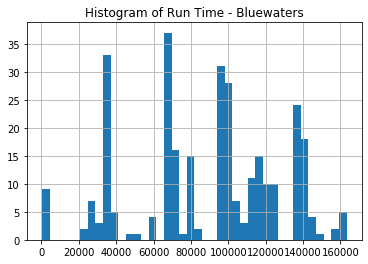

In [43]:
#Histogram of run time - actual
plt.title('Histogram of Run Time - Bluewaters')
df_bluewaters.run_time_tot.hist(bins=40)

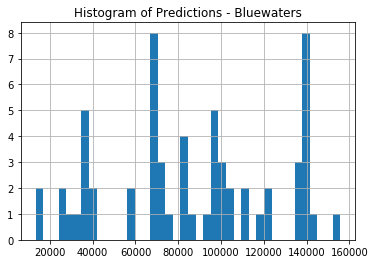

In [44]:
#Histogram of run time- predicted
plt.title('Histogram of Predictions - Bluewaters')
preds.hist(bins=40)

## Cori

In [45]:
df_cori.shape

(213, 70)

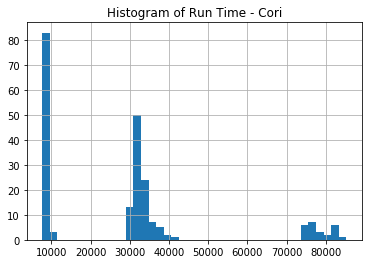

In [46]:
#Histogram of run time
plt.title('Histogram of Run Time - Cori')
df_cori.run_time_tot.hist(bins=40)

In [47]:
df_cori.run_time_tot.describe()

count      213.000000
mean     28227.811047
std      21755.577878
min       7610.343000
25%       8040.534000
50%      31088.715000
75%      33508.096000
max      85282.420000
Name: run_time_tot, dtype: float64

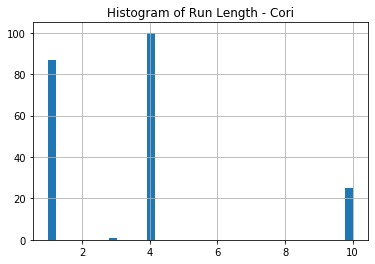

In [48]:
#Histogram of run length
plt.title('Histogram of Run Length - Cori')
df_cori.run_length_years.hist(bins=40)

In [49]:
#Drop simulations less than one year
df_cori = df_cori.loc[df_cori.run_length_years >= 1]
df_cori.shape

(213, 70)

In [50]:
df_cori.isnull().sum()

comp_pes_atm            0
comp_pes_cpl            0
comp_pes_esp          212
comp_pes_glc            0
comp_pes_ice            0
comp_pes_lnd            0
comp_pes_ocn            0
comp_pes_rof            0
comp_pes_wav            0
final_time              0
init_time_seconds       0
instances_atm           0
instances_esp         212
instances_glc           0
instances_ice           0
instances_lnd           0
instances_ocn           0
instances_rof           0
instances_wav           0
machine                 0
model_tag               1
ocn_init_wait_time      0
pes_per_node            0
root_pe_atm             0
root_pe_cpl             0
root_pe_esp           212
root_pe_glc             0
root_pe_ice             0
root_pe_lnd             0
root_pe_ocn             0
                     ... 
tasks_lnd               0
tasks_ocn               0
tasks_rof               0
tasks_wav               0
threads_atm             0
threads_cpl             0
threads_esp           212
threads_glc 

In [51]:
#Drop columns with nulls
df_cori = df_cori.drop(['instances_esp', 'root_pe_esp', 'threads_esp', 'compset_OBGC', 'tasks_esp', 'comp_pes_esp'], axis=1)

In [52]:
#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_cori, drop_first=True)
data_dummies.shape

y = data_dummies.run_time_tot                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           run_time_tot   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3416.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):          2.14e-172
Time:                        19:52:39   Log-Likelihood:                -1518.3
No. Observations:                 170   AIC:                             3053.
Df Residuals:                     162   BIC:                             3078.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

Text(0, 0.5, 'Density')

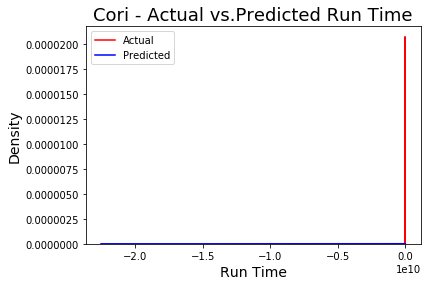

In [53]:
preds = results.predict(xTest)

ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
sns.distplot(preds, hist=False, color="b", label="Predicted" , ax=ax1)

ax1.set_title("Cori - Actual vs.Predicted Run Time", fontsize=18)
plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

## Yellowstone

In [54]:
df_yellowstone.shape

(87382, 70)

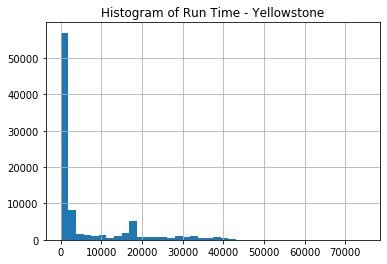

In [55]:
#Histogram of run time
plt.title('Histogram of Run Time - Yellowstone')
df_yellowstone.run_time_tot.hist(bins=40)

In [56]:
#Subset to runs less than 100 seconds for plotting
df_yellow100 = df_yellowstone.loc[df_yellowstone['run_time_tot'] <= 100]
df_yellow100.shape

(41903, 70)

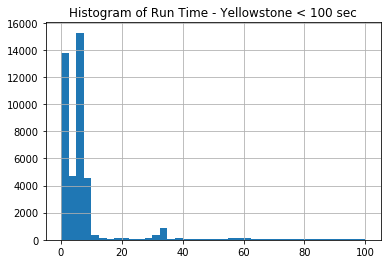

In [57]:
#Histogram of run time < 100 seconds
plt.title('Histogram of Run Time - Yellowstone < 100 sec')
df_yellow100.run_time_tot.hist(bins=40)

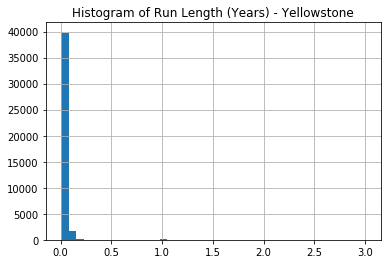

In [58]:
#Histogram of run_length
plt.title('Histogram of Run Length (Years) - Yellowstone')
df_yellow100.run_length_years.hist(bins=40)

In [59]:
#Drop all runs that are less than one year.
df_yellowstone = df_yellowstone.loc[df_yellowstone.run_length_years >= 1]

In [60]:
df_yellowstone.shape

(26223, 70)

In [61]:
df_yellowstone.isnull().sum()

comp_pes_atm              0
comp_pes_cpl              0
comp_pes_esp          25065
comp_pes_glc              0
comp_pes_ice              0
comp_pes_lnd              0
comp_pes_ocn              0
comp_pes_rof              0
comp_pes_wav              0
final_time                0
init_time_seconds         0
instances_atm             0
instances_esp         25065
instances_glc             0
instances_ice             0
instances_lnd             0
instances_ocn             0
instances_rof             0
instances_wav             0
machine                   0
model_tag              1158
ocn_init_wait_time        0
pes_per_node              0
root_pe_atm               0
root_pe_cpl               0
root_pe_esp           25065
root_pe_glc               0
root_pe_ice               0
root_pe_lnd               0
root_pe_ocn               0
                      ...  
tasks_lnd                 0
tasks_ocn                 0
tasks_rof                 0
tasks_wav                 0
threads_atm         

In [62]:
#Drop columns with nulls
df_yellowstone = df_yellowstone.drop(['instances_esp', 'root_pe_esp', 'threads_esp', 'compset_OBGC', 'tasks_esp', \
                                      'model_tag', 'comp_pes_esp'], axis=1)

#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_yellowstone, drop_first=True)
data_dummies.shape

y = data_dummies.run_time_tot                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           run_time_tot   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     532.5
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:52:43   Log-Likelihood:            -2.0350e+05
No. Observations:               20978   AIC:                         4.075e+05
Df Residuals:                   20720   BIC:                         4.096e+05
Df Model:                         257                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

Text(0, 0.5, 'Density')

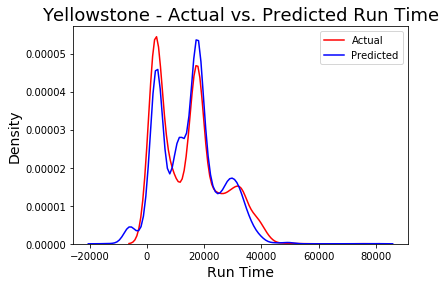

In [63]:
preds = results.predict(xTest)
 
ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
sns.distplot(preds, hist=False, color="b", label="Predicted" , ax=ax1)
ax1.set_title("Yellowstone - Actual vs. Predicted Run Time", fontsize=18)
plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

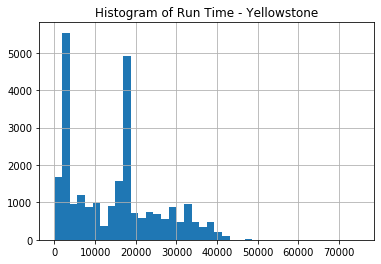

In [64]:
#Histogram of run_length
plt.title('Histogram of Run Time - Yellowstone')
df_yellowstone.run_time_tot.hist(bins=40)

### Log Transform

See how taking the log of run_time_tot changes the model:

In [65]:
df_yellowstone_log = df_yellowstone.copy()
df_yellowstone_log['run_time_tot'] = np.log(df_yellowstone['run_time_tot'])

#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_yellowstone_log, drop_first=True)
data_dummies.shape

y = data_dummies.run_time_tot                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           run_time_tot   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     1282.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:52:46   Log-Likelihood:                -3700.6
No. Observations:               20978   AIC:                             7917.
Df Residuals:                   20720   BIC:                             9969.
Df Model:                         257                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

Text(0, 0.5, 'Density')

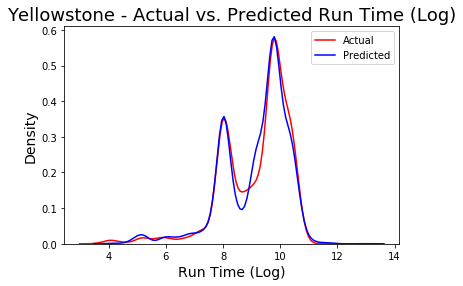

In [66]:
preds = results.predict(xTest)
 
ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
sns.distplot(preds, hist=False, color="b", label="Predicted" , ax=ax1)
ax1.set_title("Yellowstone - Actual vs. Predicted Run Time (Log)", fontsize=18)
plt.xlabel('Run Time (Log)', fontsize=14)
plt.ylabel('Density', fontsize=14)

## Cheyenne

In [67]:
df_cheyenne.shape

(226859, 70)

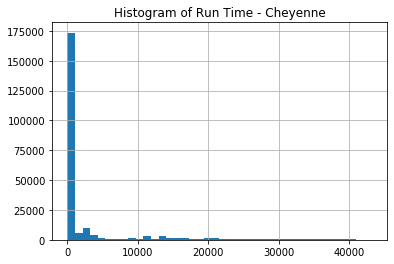

In [68]:
#Histogram of run_time_tot
plt.title('Histogram of Run Time - Cheyenne')
df_cheyenne.run_time_tot.hist(bins=40)

In [69]:
#Subset to runs less than 100 seconds for plotting
df_cheyenne100 = df_cheyenne.loc[df_cheyenne['run_time_tot'] <= 100]
df_cheyenne100.shape

(146668, 70)

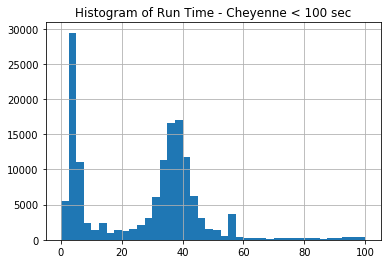

In [70]:
#Histogram of run time < 100 seconds
plt.title('Histogram of Run Time - Cheyenne < 100 sec')
df_cheyenne100.run_time_tot.hist(bins=40)

There are a lot of runs of less than 10 seconds. Let's also look at the run_length_years for those short runs:

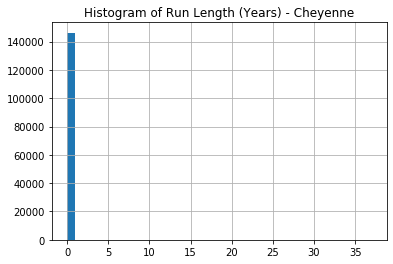

In [71]:
#Histogram of run_length_years
plt.title('Histogram of Run Length (Years) - Cheyenne')
df_cheyenne100.run_length_years.hist(bins=40)

In [72]:
#Take only runs that last longer than one minute (60 sec)
df_cheyenne = df_cheyenne.loc[df_cheyenne.run_time_tot >= 60]

In [73]:
df_cheyenne.shape

(84302, 70)

In [74]:
#Drop all runs that are less than one year
df_cheyenne = df_cheyenne.loc[df_cheyenne.run_length_years >= 1]
df_cheyenne.shape

(48313, 70)

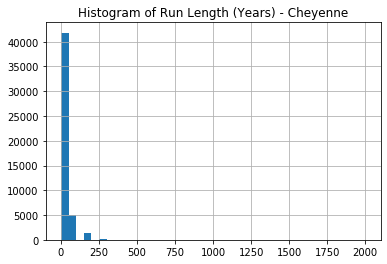

In [75]:
#Histogram of run length_years
plt.title('Histogram of Run Length (Years) - Cheyenne')
df_cheyenne.run_length_years.hist(bins=40)

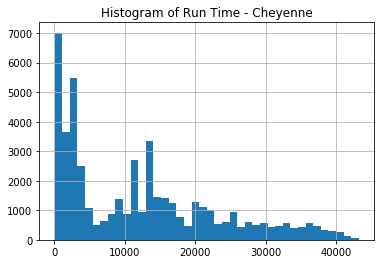

In [76]:
#Histogram of run_time_tot
plt.title('Histogram of Run Time - Cheyenne')
df_cheyenne.run_time_tot.hist(bins=40)

In [77]:
df_cheyenne.shape

(48313, 70)

In [78]:
df_cheyenne.isnull().sum()

comp_pes_atm              0
comp_pes_cpl              0
comp_pes_esp          14226
comp_pes_glc              0
comp_pes_ice              0
comp_pes_lnd              0
comp_pes_ocn              0
comp_pes_rof              0
comp_pes_wav              0
final_time                0
init_time_seconds         0
instances_atm             0
instances_esp         14226
instances_glc             0
instances_ice             0
instances_lnd             0
instances_ocn             0
instances_rof             0
instances_wav             0
machine                   0
model_tag             34087
ocn_init_wait_time        0
pes_per_node              0
root_pe_atm               0
root_pe_cpl               0
root_pe_esp           14226
root_pe_glc               0
root_pe_ice               0
root_pe_lnd               0
root_pe_ocn               0
                      ...  
tasks_lnd                 0
tasks_ocn                 0
tasks_rof                 0
tasks_wav                 0
threads_atm         

In [79]:
#Drop some columns with nulls
df_cheyenne = df_cheyenne.drop(['instances_esp', 'root_pe_esp', 'threads_esp', 'compset_OBGC', 'tasks_esp',\
                               'comp_pes_esp'], axis=1)

#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_cheyenne, drop_first=True)
data_dummies.shape

y = data_dummies.run_time_tot                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           run_time_tot   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     999.3
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:52:59   Log-Likelihood:            -3.6941e+05
No. Observations:               38650   AIC:                         7.395e+05
Df Residuals:                   38296   BIC:                         7.426e+05
Df Model:                         353                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

Text(0, 0.5, 'Density')

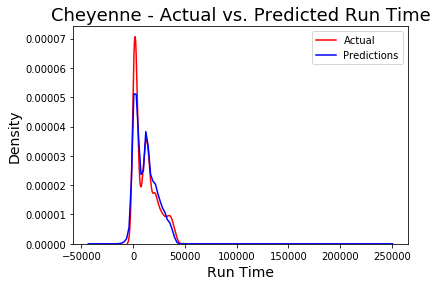

In [80]:
preds = results.predict(xTest)
 
ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
sns.distplot(preds, hist=False, color="b", label="Predictions" , ax=ax1)
ax1.set_title("Cheyenne - Actual vs. Predicted Run Time", fontsize=18)
plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

In [81]:
yTest.describe()

count     9663.000000
mean     12154.612770
std      11076.299645
min         60.771000
25%       2501.120000
50%      10695.915000
75%      19457.115500
max      42944.378000
Name: run_time_tot, dtype: float64

In [82]:
preds.describe()

count      9663.000000
mean      12149.374335
std       10751.172023
min      -37813.413687
25%        3107.340457
50%       12045.677484
75%       19585.314156
max      245392.179234
dtype: float64

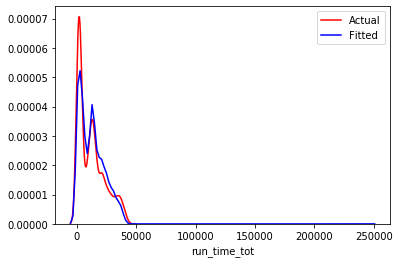

In [83]:
#There are some crazy negative predictions here
#Drop the negatives and replot
preds1 = preds[preds >= 0]  

ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
sns.distplot(preds1, hist=False, color="b", label="Fitted" , ax=ax1)

### Log Transform

To constrain the model to just positive values, let's take the log of run_time_tot:

In [84]:
df_cheyenne_log = df_cheyenne.copy()
df_cheyenne_log['run_time_tot'] = np.log(df_cheyenne['run_time_tot'])

In [85]:
#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_cheyenne_log, drop_first=True)
data_dummies.shape

y = data_dummies.run_time_tot                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           run_time_tot   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1480.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:53:10   Log-Likelihood:                -14769.
No. Observations:               38650   AIC:                         3.025e+04
Df Residuals:                   38296   BIC:                         3.328e+04
Df Model:                         353                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

Text(0, 0.5, 'Density')

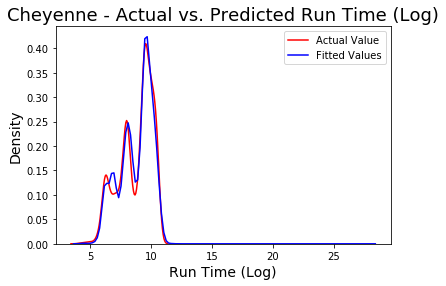

In [86]:
preds = results.predict(xTest)

ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual Value")
sns.distplot(preds, hist=False, color="b", label="Fitted Values" , ax=ax1)

ax1.set_title("Cheyenne - Actual vs. Predicted Run Time (Log)", fontsize=18)
plt.xlabel('Run Time (Log)', fontsize=14)
plt.ylabel('Density', fontsize=14)

Much better!

### Select Features

In [131]:
#Subset just a few columns
df_cheyenne_select = df_cheyenne[['compset_atm', 'compset_prefix', 'compset_ocn', 'grid_atm', 'grid_oi', \
                                  'run_length_years', 'run_time_tot']]

#df_cheyenne_select_log = df_cheyenne_select.copy()
#df_cheyenne_select_log['run_time_tot'] = np.log(df_cheyenne_select['run_time_tot'])

In [121]:
df_cheyenne_select.run_length_years.describe()

count    48313.000000
mean        20.625470
std         44.920737
min          1.000000
25%          1.000000
50%          4.000000
75%         10.000000
max       2000.000000
Name: run_length_years, dtype: float64

In [122]:
#Histogram of model cost
fig = px.histogram(df_cheyenne_select, x="run_length_years", title = "Histogram of Simulated Years")
fig.show()

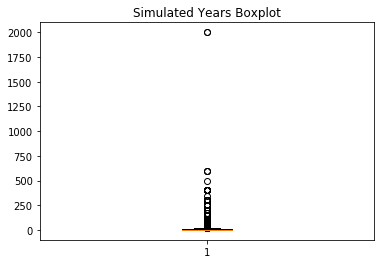

In [123]:
plt.boxplot(df_cheyenne_select["run_length_years"])
plt.title('Simulated Years Boxplot')
plt.show()

In [124]:
df_2000 = df_cheyenne_select[df_cheyenne_select.run_length_years == 2000]
df_2000

compset_atm compset_prefix compset_ocn grid_atm  grid_oi  \
247798        SATM           HIST        SOCN   a%null  oi%null   
266640        SATM           HIST        SOCN   a%null  oi%null   

        run_length_years  run_time_tot  
247798            2000.0      8033.546  
266640            2000.0      9757.808

In [126]:
df_250 = df_cheyenne_select[df_cheyenne_select.run_length_years >= 250]
df_250.shape

(110, 7)

In [127]:
df_250.compset_atm.unique()

array(['DATM%1PT', 'DATM%GSWP3v1', 'SATM', 'DATM%QIA'], dtype=object)

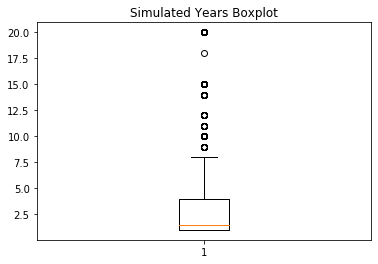

In [133]:
#Drop DATM
df_NODATM = df_cheyenne_select[~df_cheyenne_select.compset_atm.str.contains("DAT")]
df_NOSATM = df_NODATM[~df_NODATM.compset_atm.str.contains("SAT")]
plt.boxplot(df_NOSATM["run_length_years"])
plt.title('Simulated Years Boxplot')
plt.show()

In [137]:
df_NODATM.shape

(22486, 7)

In [136]:
df_cheyenne_select.shape


(48313, 7)

In [119]:
#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_cheyenne_select, drop_first=True)
data_dummies.shape

y = data_dummies.run_time_tot                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           run_time_tot   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              1685.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):                        0.00
Time:                        19:54:47   Log-Likelihood:                     -3.9401e+05
No. Observations:               38650   AIC:                                  7.883e+05
Df Residuals:                   38526   BIC:                                  7.893e+05
Df Model:                         124                                                  
Covariance Type:            nonrobust                                                  
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------

Text(0, 0.5, 'Density')

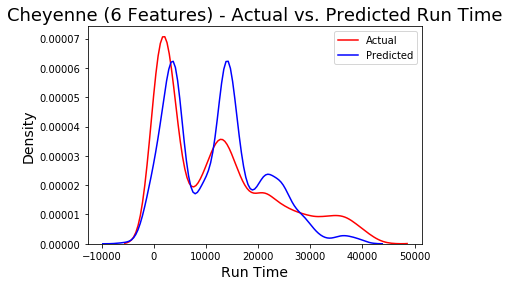

In [138]:
preds = results.predict(xTest)

ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
sns.distplot(preds, hist=False, color="b", label="Predicted" , ax=ax1)

ax1.set_title("Cheyenne (6 Features) - Actual vs. Predicted Run Time", fontsize=18)
plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

In [90]:
#Plot Correlation Coefficients
df = pd.DataFrame(results.params)
df = df.reset_index()
df.columns = (['Feature', 'Coef'])
df = df.sort_values(by=['Coef'])

fig = px.bar(df, y="Feature", x="Coef", orientation='h', height=2000, title ='Cheyenne - Correlation Coefficient Importance')
#plt.bar(df.index, df.error.values, width=20)

fig.show()

In [91]:
df_chey

Id            LID  \
0        /glade/scratch/bdobbins/projects/Database/Gla...  180508-185620   
1        /glade/scratch/bdobbins/projects/Database/Gla...  181030-212017   
2        /glade/scratch/bdobbins/projects/Database/Gla...  181030-000151   
3        /glade/scratch/bdobbins/projects/Database/Gla...  150315-113454   
4        /glade/scratch/bdobbins/projects/Database/Gla...  140210-180221   
5        /glade/scratch/bdobbins/projects/Database/Gla...  180420-031959   
6        /glade/scratch/bdobbins/projects/Database/Gla...  181030-000517   
7        /glade/scratch/bdobbins/projects/Database/Gla...  180419-114235   
8        /glade/scratch/bdobbins/projects/Database/Gla...  180419-093338   
9        /glade/scratch/bdobbins/projects/Database/Gla...  180420-000757   
10       /glade/scratch/bdobbins/projects/Database/Gla...  181029-144020   
11       /glade/scratch/bdobbins/projects/Database/Gla...  180508-125551   
12       /glade/scratch/bdobbins/projects/Database/Gla...  161210-175530   
13       /glade/scratch/bdobbins/projects/Database/Gla...  170911-074653   
14       /glade/scratch/bdobbins/projects/Database/Gla...  141211-021708   
15       /glade/scratch/bdobbins/projects/Database/Gla...  150202-165711   
16       /glade/scratch/bdobbins/projects/Database/Gla...  181029-111643   
17       /glade/scratch/bdobbins/projects/Database/Gla...  180421-000538   
18       /glade/scratch/bdobbins/projects/Database/Gla...  180420-114843   
19       /glade/scratch/bdobbins/projects/Database/Gla...  170512-051400   
20       /glade/scratch/bdobbins/projects/Database/Gla...  181030-031800   
21       /glade/scratch/bdobbins/projects/Database/Gla...  181026-194938   
22       /glade/scratch/bdobbins/projects/Database/Gla...  171128-205447   
23       /glade/scratch/bdobbins/projects/Database/Gla...  161214-135724   
24       /glade/scratch/bdobbins/projects/Database/Gla...  150310-082643   
25       /glade/scratch/bdobbins/projects/Database/Gla...  180423-210136   
26       /glade/scratch/bdobbins/projects/Database/Gla...  180508-112604   
27       /glade/scratch/bdobbins/projects/Database/Gla...  180420-212542   
28       /glade/scratch/bdobbins/projects/Database/Gla...  180420-223743   
29       /glade/scratch/bdobbins/projects/Database/Gla...  180508-221529   
...                                                   ...            ...   
314931   /glade/scratch/bdobbins/projects/Database/Gla...  171217-123121   
314932   /glade/scratch/bdobbins/projects/Database/Gla...  150527-135152   
314933   /glade/scratch/bdobbins/projects/Database/Gla...  150903-181346   
314934   /glade/scratch/bdobbins/projects/Database/Gla...  150908-150112   
314935   /glade/scratch/bdobbins/projects/Database/Gla...  150908-105041   
314936   /glade/scratch/bdobbins/projects/Database/Gla...  151218-194808   
314937   /glade/scratch/bdobbins/projects/Database/Gla...  160811-132052   
314938   /glade/scratch/bdobbins/projects/Database/Gla...  151219-030004   
314939   /glade/scratch/bdobbins/projects/Database/Gla...  151015-135214   
314940   /glade/scratch/bdobbins/projects/Database/Gla...  160831-201500   
314941   /glade/scratch/bdobbins/projects/Database/Gla...  161201-020146   
314942   /glade/scratch/bdobbins/projects/Database/Gla...  151002-154244   
314943   /glade/scratch/bdobbins/projects/Database/Gla...  150720-142407   
314944   /glade/scratch/bdobbins/projects/Database/Gla...  160813-230943   
314945   /glade/scratch/bdobbins/projects/Database/Gla...  150804-133543   
314946   /glade/scratch/bdobbins/projects/Database/Gla...  170915-023350   
314947   /glade/scratch/bdobbins/projects/Database/Gla...  151222-080421   
314948   /glade/scratch/bdobbins/projects/Database/Gla...  151116-090025   
314949   /glade/scratch/bdobbins/projects/Database/Gla...  171216-010346   
314950   /glade/scratch/bdobbins/projects/Database/Gla...  150908-145242   
314951   /glade/scratch/bdobbins/projects/Database/Gla...  150923-200433   
314952   /glade/scratch/bdo

In [92]:
#Plot model_cost per atm component
#Filter cheyenne data as above
df_chey = df_chey[df_chey.machine == 'cheyenne']
df_chey = df_chey.loc[df_chey.run_time_tot >= 60]
df_chey = df_chey.loc[df_chey.run_length_years >= 1]
#Drop DATM compsets
df_chey = df_chey[~df_chey.compset_atm.str.contains("DAT")]

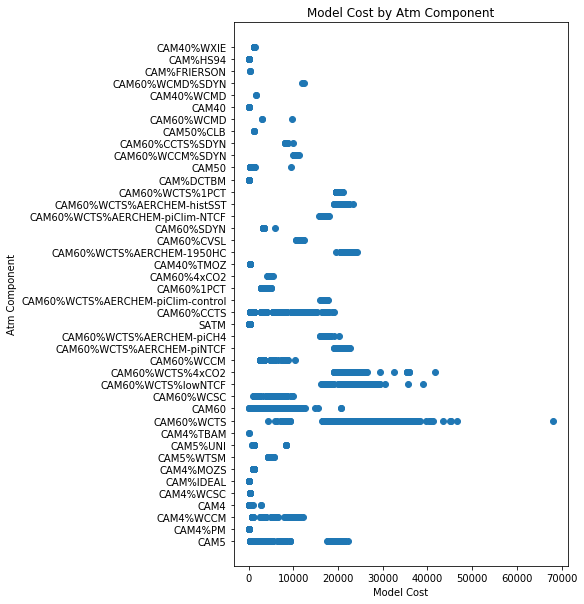

In [93]:
plt.figure(figsize=(6,10))
plt.scatter(df_chey['model_cost'], df_chey['compset_atm'])
plt.xlabel('Model Cost')
plt.ylabel('Atm Component')
plt.title('Model Cost by Atm Component')
plt.show()

In [94]:
#Look at just CAM60%WCTS,the component with the widest spread

In [95]:
df_wcts = df_chey[df_chey.compset_atm == 'CAM60%WCTS']
df_wcts.shape

(1465, 97)

In [96]:
#Histogram of model cost
fig = px.histogram(df_wcts, x="model_cost", title = "Histogram of Model Cost - CAM60%WCTS")
fig.show()

In [97]:
df_chey.columns.values

array(['Id', 'LID', 'Timeroot', 'case', 'caseroot', 'comp_pes_atm',
       'comp_pes_cpl', 'comp_pes_esp', 'comp_pes_glc', 'comp_pes_ice',
       'comp_pes_lnd', 'comp_pes_ocn', 'comp_pes_rof', 'comp_pes_wav',
       'compset', 'curr_date', 'final_time', 'grid', 'init_time_seconds',
       'instances_atm', 'instances_esp', 'instances_glc', 'instances_ice',
       'instances_lnd', 'instances_ocn', 'instances_rof', 'instances_wav',
       'machine', 'model_cost', 'model_tag', 'model_throughput',
       'ocn_init_wait_time', 'parser', 'pe_count', 'pes_per_node',
       'root_pe_atm', 'root_pe_cpl', 'root_pe_esp', 'root_pe_glc',
       'root_pe_ice', 'root_pe_lnd', 'root_pe_ocn', 'root_pe_rof',
       'root_pe_wav', 'run_time_atm', 'run_time_cpl', 'run_time_cplcomm',
       'run_time_esp', 'run_time_glc', 'run_time_ice', 'run_time_lnd',
       'run_time_ocn', 'run_time_rof', 'run_time_seconds',
       'run_time_seconds_per_day', 'run_time_tot', 'run_time_wav',
       'run_type', 'stop_opti

In [98]:
df_wcts.columns.values

array(['Id', 'LID', 'Timeroot', 'case', 'caseroot', 'comp_pes_atm',
       'comp_pes_cpl', 'comp_pes_esp', 'comp_pes_glc', 'comp_pes_ice',
       'comp_pes_lnd', 'comp_pes_ocn', 'comp_pes_rof', 'comp_pes_wav',
       'compset', 'curr_date', 'final_time', 'grid', 'init_time_seconds',
       'instances_atm', 'instances_esp', 'instances_glc', 'instances_ice',
       'instances_lnd', 'instances_ocn', 'instances_rof', 'instances_wav',
       'machine', 'model_cost', 'model_tag', 'model_throughput',
       'ocn_init_wait_time', 'parser', 'pe_count', 'pes_per_node',
       'root_pe_atm', 'root_pe_cpl', 'root_pe_esp', 'root_pe_glc',
       'root_pe_ice', 'root_pe_lnd', 'root_pe_ocn', 'root_pe_rof',
       'root_pe_wav', 'run_time_atm', 'run_time_cpl', 'run_time_cplcomm',
       'run_time_esp', 'run_time_glc', 'run_time_ice', 'run_time_lnd',
       'run_time_ocn', 'run_time_rof', 'run_time_seconds',
       'run_time_seconds_per_day', 'run_time_tot', 'run_time_wav',
       'run_type', 'stop_opti

In [99]:
#Subset to CAM60%WCTS
df_wcts = df_cheyenne[df_cheyenne.compset_atm == 'CAM60%WCTS']
df_wcts.shape

(1465, 64)

In [100]:
#Subset again based on correlation coefficients from df_wcts model (not shown)
df_sub = df_wcts[['compset_prefix', 'compset_land', 'run_length_years', 'grid_mask', 'grid_oi', 'grid_lnd', 'run_time_tot']]

In [101]:
#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_sub, drop_first=True)

y = data_dummies['run_time_tot']                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           run_time_tot   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              6535.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):                        0.00
Time:                        19:53:19   Log-Likelihood:                         -10954.
No. Observations:                1172   AIC:                                  2.194e+04
Df Residuals:                    1155   BIC:                                  2.203e+04
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------

Text(0, 0.5, 'Density')

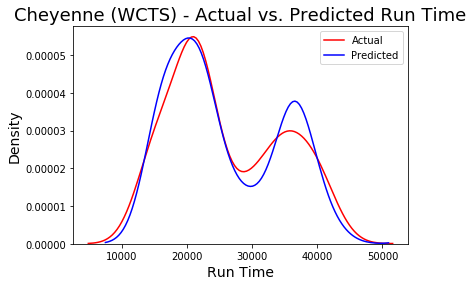

In [102]:
preds = results.predict(xTest)

ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
sns.distplot(preds, hist=False, color="b", label="Predicted" , ax=ax1)

ax1.set_title("Cheyenne (WCTS) - Actual vs. Predicted Run Time", fontsize=18)
plt.xlabel('Run Time', fontsize=14)
plt.ylabel('Density', fontsize=14)

In [103]:
#Plot Correlation Coefficients
df = pd.DataFrame(results.params)
df = df.reset_index()
df.columns = (['Feature', 'Coef'])
df = df.sort_values(by=['Coef'])

fig = px.bar(df, y="Feature", x="Coef", orientation='h', height=700, title ='CAM60%WCTS - Correlation Coefficient Importance')
#plt.bar(df.index, df.error.values, width=20)

fig.show()

In [104]:
df_plot = df_chey[df_chey.compset_atm == 'CAM60%WCTS']

In [105]:
df_plot.run_length_years.unique()

array([1.        , 2.        , 1.50410959, 1.50136986, 1.49589041,
       1.49863014, 1.49315068, 1.16712329, 1.24657534, 1.00273973])

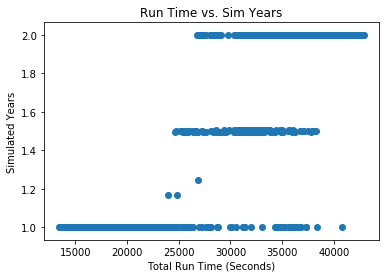

In [106]:
#Look at run_time_tot vs run_length_years
plt.scatter(df_wcts['run_time_tot'], df_wcts['run_length_years'])
plt.xlabel('Total Run Time (Seconds)')
plt.ylabel('Simulated Years')
plt.title('Run Time vs. Sim Years')
plt.show()

In [107]:
df_try = df_modeling[df_modeling.machine == 'cheyenne']

In [108]:
df_try_try = df_try[df_try.compset_atm == 'CAM60%WCTS']

In [109]:
df_try_try.run_length_years.unique()

array([1.        , 0.02739726, 0.08493151, 2.        , 0.01369863,
       0.49315068, 0.49589041, 0.49863014, 1.50410959, 1.50136986,
       1.49589041, 0.04383562, 1.49863014, 0.03287671, 0.01643836,
       0.00273973, 0.50410959, 0.33424658, 1.49315068, 0.49041096,
       0.50136986, 0.03561644, 0.33150685, 0.12328767, 0.04931507,
       0.03013699, 0.03835616, 0.3369863 , 0.32876712, 0.05479452,
       1.16712329, 0.58356164, 0.05205479, 1.24657534, 0.16164384,
       0.95890411, 0.66575342, 0.75068493, 0.00547945, 0.25205479,
       0.24657534, 0.4109589 , 0.91506849, 0.58630137, 0.02191781,
       0.00821918, 0.58082192, 0.20547945, 0.6630137 , 0.24383562,
       0.07123288, 0.05753425, 0.16986301, 0.0109589 , 0.41369863,
       0.04109589, 0.83013699, 0.06575342, 0.04657534, 0.08219178,
       0.01917808, 1.00273973, 0.02465753, 0.98630137, 0.08767123,
       0.83287671, 0.83835616, 0.48219178, 0.24931507, 0.67123288,
       0.8739726 , 0.41643836, 0.07671233])

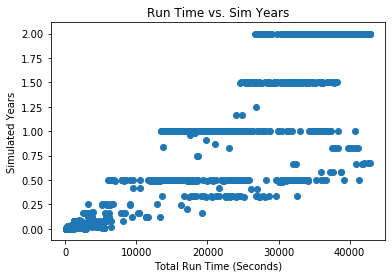

In [110]:
#Look at run_time_tot vs run_length_years
plt.scatter(df_try_try['run_time_tot'], df_try_try['run_length_years'])
plt.xlabel('Total Run Time (Seconds)')
plt.ylabel('Simulated Years')
plt.title('Run Time vs. Sim Years')
plt.show()

In [111]:
#Subset again based on correlation coefficients from df_wcts model (not shown)
df_sub_try = df_try_try[['compset_prefix', 'compset_land', 'run_length_years', 'grid_mask', 'grid_oi', 'grid_lnd', 'run_time_tot']]
#Create dummy variables from categorical data
data_dummies = pd.get_dummies(df_sub_try, drop_first=True)

y = data_dummies['run_time_tot']                             # define the target variable (dependent variable) as y
x = data_dummies.drop(['run_time_tot'], axis = 1)         # the data without the target

#Training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

model = sm.OLS(yTrain, xTrain)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           run_time_tot   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              1921.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):                        0.00
Time:                        19:53:22   Log-Likelihood:                         -19527.
No. Observations:                1977   AIC:                                  3.910e+04
Df Residuals:                    1954   BIC:                                  3.923e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------

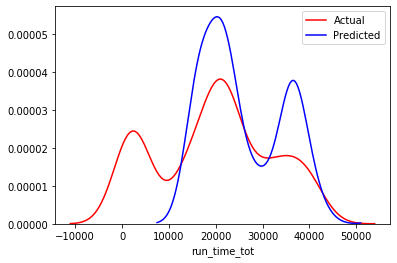

In [112]:
ax1 = sns.distplot(yTest, hist=False, color="r", label="Actual")
sns.distplot(preds, hist=False, color="b", label="Predicted" , ax=ax1)

In [113]:
#Plot Correlation Coefficients
df = pd.DataFrame(results.params)
df = df.reset_index()
df.columns = (['Feature', 'Coef'])
df = df.sort_values(by=['Coef'])

fig = px.bar(df, y="Feature", x="Coef", orientation='h', height=700, title ='CAM60%WCTS - Correlation Coefficient Importance')
#plt.bar(df.index, df.error.values, width=20)

fig.show()

# Unsupervised Learning

In [114]:
xx
import numpy as np
from kmodes.kmodes import KModes

NameError: name 'xx' is not defined

In [ ]:
# random categorical data
df_cheyenne_nonull = df_cheyenne.dropna()

km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(df_cheyenne_nonull)

# Print the cluster centroids
print(km.cluster_centroids_)

In [ ]:
from kmodes import kmodes
df_dummy = pd.get_dummies(df_cheyenne_nonull)

#transform into numpy array
x = df_dummy.reset_index().values

km = kmodes.KModes(n_clusters=3, init='Huang', n_init=5, verbose=0)
clusters = km.fit_predict(x)
df_dummy['clusters'] = clusters


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(2)

# Turn the dummified df into two columns with PCA
plot_columns = pca.fit_transform(df_dummy.ix[:,0:12])

# Plot based on the two dimensions, and shade by cluster label
plt.scatter(x=plot_columns[:,1], y=plot_columns[:,0], c=df_dummy["clusters"], s=30)
plt.show()

In [ ]:
km.cluster_centroids_

# Discussion
The actual vs. fitted plots for both models look exactly alike, so perhaps the linear regression is using ordinary least squares, which is a type of linear regression anyway. As I suggested, the model is a closer fit for the lower values of the run_time, and less accurate for higher run times where we saw the higher spread of costs vs. components or grids.

On the MLR model, the coefficients for tasks and init_time_sec are much, much smaller than for the other variables, so we may be able to take those out next time to tune the model. The OLS model shows similar results. The large coefficients for the variables other than tasks and inti_time indicate a strong relationship with the dependent variable run_time_atm.

I have more performance data on the OLS model, so I'll talk about that here:

For R-squared, closer to 1 is better, and the OLS model has R-squared= 0.76, which is decent. However, AIC is very large, which indicates a poor model. F-statistic is large (which is good), at 722. So the stats kind of go all over the place, and mostly I trust the R-squared stat and the plot, which really shows what the model is doing.

## Lessons Learned
This was a good refresher on creating training and test sets, running models, and looking for co-multilinearity. In the final models that you see above, other features that I had originally included have been weeded out.

## Suggestions
I feel like I am rusty on my modeling techniques and could use a thorough review on interpreting the parametric regression results and also on how to tune models. The book was pretty vague on interpreting the regression results. 